# Banknote Dataset

In [7]:
# Import packages
from Bias import BIASme, bias_rotate_2D
from Transformations import remove_outliers_lof, trafo_ica
from DensityEstimators import DE_histogram, DE_kde
from IMITATE import IMITATE
from sklearn import svm
from scipy import stats
import pandas as pd
import numpy as np
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
# class label = sex
def loadData_banknote_complete(dataset_size=1372):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
    dataset = pd.read_csv(url, header=None)
    y = dataset[4].to_numpy()
    isInB = np.array([dataset.to_numpy()[i,0]>0.32 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    X = dataset.drop([4], axis=1).to_numpy()
    X = np.append(X, isInB, axis=1)
    
    return X, y

[Text(167.4, 163.07999999999998, 'X[0] <= 0.32\ngini = 0.494\nsamples = 1372\nvalue = [762, 610]'),
 Text(83.7, 54.360000000000014, 'gini = 0.306\nsamples = 657\nvalue = [124, 533]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.192\nsamples = 715\nvalue = [638, 77]')]

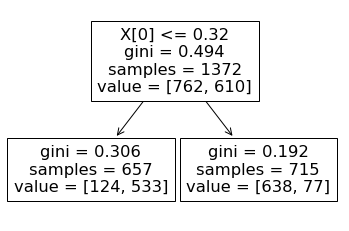

In [18]:
# quick check for the most predictive attribute:
from sklearn import tree
X, y = loadData_banknote_complete()
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X[:,0:len(X[0])-1],y)
tree.plot_tree(clf)

In [3]:
# remove all mushrooms with rings <= 8
def bias_banknote(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1]
    X = X[:, 0:(len(data[0])-1)]
    y = labels[isInB==1]
    return X, y

## COMPLETE case: we use one attribute for the bias but still keep it as an attribute

In [12]:
def run_and_eval(model, runs=10):
    acc_init = np.zeros(runs)
    acc_final = np.zeros(runs)
    hist_bins = list(range(10,30,3))
    
    for r in range(runs):
        bh = run_experiment(hist_bins, model=model, repeat=2)
        acc_init[r] = bh.D.acc_unbiased - bh.D.acc_init
        acc_final[r] = bh.D.acc_unbiased - bh.D.accuracyBiased(bh.added_points, bh.added_labels)
        print("run", r, "- acc_i =", acc_init[r], " acc_f =", acc_final[r])

    return acc_init, acc_final

In [13]:
def run_experiment(num_bins, model, repeat=10):
    DE = DE_histogram
    data_gen = loadData_banknote_complete
    bias_gen = bias_banknote
    bh = IMITATE([10], bias_gen, data_gen, repeat=1, DE=DE, trafo=trafo_ica, model=model)
    
    # run 10 times, pick the result with the highest confidence
    max_conf = 0
    for bins in num_bins:
        for i in range(repeat):
            bh.reset()
            label_conf = bh.fill_up(num_bins=bins, iterations=10, fill_up_plots=False, point_plots=False, RO=True)
            #print("run", i, ", conf", label_conf)
            if max(label_conf) >= max_conf:
                max_conf = max(label_conf)
                best_bh = copy.deepcopy(bh)
    return best_bh

### Linear SVM

In [45]:
model = svm.SVC(kernel='linear')
res = run_and_eval()

run 0 - acc_i = 0.21116504854368934  acc_f = 0.15291262135922334
run 1 - acc_i = 0.21116504854368934  acc_f = 0.21359223300970875
run 2 - acc_i = 0.22330097087378642  acc_f = 0.17961165048543692
run 3 - acc_i = 0.22815533980582525  acc_f = 0.18446601941747576
run 4 - acc_i = 0.20145631067961167  acc_f = 0.20145631067961167
run 5 - acc_i = 0.25485436893203883  acc_f = 0.22815533980582525
run 6 - acc_i = 0.20873786407766992  acc_f = 0.16504854368932043
run 7 - acc_i = 0.2184466019417476  acc_f = 0.1601941747572816
run 8 - acc_i = 0.2184466019417476  acc_f = 0.14077669902912626
run 9 - acc_i = 0.20145631067961167  acc_f = 0.1310679611650486


In [49]:
np.average(res, axis=1)

array([0.21771845, 0.17572816])

In [54]:
stats.ttest_ind(res[0], res[1])

Ttest_indResult(statistic=3.756827685331084, pvalue=0.0014438122439624362)

### Decision Tree

In [25]:
model = tree.DecisionTreeClassifier
res_tree = run_and_eval(model=model)

run 0 - acc_i = 0.21116504854368934  acc_f = 0.21116504854368934
run 1 - acc_i = 0.1893203883495146  acc_f = 0.1480582524271845
run 2 - acc_i = 0.2038834951456311  acc_f = 0.16504854368932043
run 3 - acc_i = 0.21116504854368934  acc_f = 0.16504854368932043
run 4 - acc_i = 0.2038834951456311  acc_f = 0.19660194174757284
run 5 - acc_i = 0.19660194174757284  acc_f = 0.1165048543689321
run 6 - acc_i = 0.18203883495145634  acc_f = 0.133495145631068
run 7 - acc_i = 0.19660194174757284  acc_f = 0.1601941747572816
run 8 - acc_i = 0.17961165048543692  acc_f = 0.16990291262135926
run 9 - acc_i = 0.1893203883495146  acc_f = 0.11165048543689327


In [26]:
np.average(res_tree, axis=1)

array([0.19635922, 0.15776699])

In [27]:
stats.ttest_ind(res_tree[0], res_tree[1])

Ttest_indResult(statistic=3.6131179897237504, pvalue=0.001988317562475203)

### SVM with RBF kernel

In [22]:
model = svm.SVC(kernel='rbf')
res_rbf = run_and_eval(model=model)

run 0 - acc_i = 0.2184466019417476  acc_f = 0.2184466019417476
run 1 - acc_i = 0.17961165048543692  acc_f = 0.162621359223301
run 2 - acc_i = 0.1747572815533981  acc_f = 0.1747572815533981
run 3 - acc_i = 0.2354368932038835  acc_f = 0.162621359223301
run 4 - acc_i = 0.18689320388349517  acc_f = 0.09951456310679607
run 5 - acc_i = 0.2063106796116505  acc_f = 0.2063106796116505
run 6 - acc_i = 0.191747572815534  acc_f = 0.191747572815534
run 7 - acc_i = 0.19417475728155342  acc_f = 0.12378640776699035
run 8 - acc_i = 0.2354368932038835  acc_f = 0.12621359223300976
run 9 - acc_i = 0.23058252427184467  acc_f = 0.15776699029126218


In [23]:
np.average(res_rbf, axis=1)

array([0.20533981, 0.16237864])

In [24]:
stats.ttest_ind(res_rbf[0], res_rbf[1])

Ttest_indResult(statistic=3.060989067666796, pvalue=0.006729148969695345)